In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Embedding vectors

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

In [ ]:
# df로 가져오는 경우
# 텍스트
df = pd.read_csv('/content/drive/MyDrive/model_save/df_SBERT_model_vectors')
df['embedding_list'] = df['embedding_list'].apply(lambda x: np.float32(eval(x)))
word_embedding = np.array(df['embedding_list'].tolist())
# 이미지
imgae_df = pd.read_csv('/content/drive/MyDrive/model_save/df_densenet768_vectors')
rows_as_list = []
for index, row in imgae_df.iterrows():
    rows_as_list.append(row.tolist())
img_embedding = np.float32(rows_as_list)

# 정규화
word_embedding = normalize(word_embedding, norm='l2')
img_embedding = normalize(img_embedding, norm='l2')

# shape 확인
print(word_embedding.shape)
print(img_embedding.shape)

(16986, 768)
(16986, 768)


Generate sample for text & image embeddings

In [ ]:
# 확인하기 편하도록 Dataframe 에서 생성값 관리
df_embeddings = pd.DataFrame({
    'text_vector':pd.Series(word_embedding.tolist()),
    'image_vector':pd.Series(img_embedding.tolist()),
})
df_embeddings['id'] = range(0,0+len(df_embeddings))
df_embeddings.tail()

,text_vector,image_vector,id
16981,"[-0.03154049068689346, 0.04707972705364227, -0...","[0.012266598641872406, 0.044624242931604385, 0...",16981
16982,"[-0.02046445570886135, 0.01766735501587391, 0....","[0.18272081017494202, 0.09039781242609024, 0.0...",16982
16983,"[-0.012973637320101261, 0.022171294316649437, ...","[0.1162426769733429, 0.06795500963926315, 0.06...",16983
16984,"[-0.022815126925706863, -0.012922593392431736,...","[0.046700410544872284, 0.014047943986952305, 0...",16984
16985,"[-0.01002886425703764, 0.04728440195322037, 0....","[0.025792423635721207, 0.019056914374232292, 0...",16985


Similarity check

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def euclidean_dist(x, y):
    ret= np.sqrt(np.sum((x - y) ** 2))
    return ret

def euclidean_similarity(x, y):
    ret = np.linalg.norm(x-y)
    ret = 1/(1+ret)   # conversion from a distance to a similarity
    return ret

vector_a = np.array(df_embeddings['text_vector'][5])
vector_b = np.array(df_embeddings['image_vector'][5])
ret1 = cosine_similarity([vector_a], [vector_b])
ret2 = euclidean_dist(vector_a, vector_b)
ret3 = euclidean_similarity(vector_a, vector_b)

print(ret1)
print(ret2)
print(ret3)

[[0.02653046]]
1.3953275314834621
0.41747944147775273


# Learning siamese network with a contrastive loss

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow import keras
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

creating training data pairs

In [ ]:
# conrastivel loss training을 위한 pair labeling

cat_df = df[['cat','cat1','cat2','cat3']]
cat_df.tail(5)

pairs = []
labels = []

# positive pairs example
for n in range(len(word_embedding)):
  pairs += [[word_embedding[n], img_embedding[n]]]
  # 같은 카테고리
  labels += '1'

# negative pairs example
for n in range(len(word_embedding)-1):
  if cat_df.loc[n,'cat'] != cat_df.loc[n+1,'cat']:
    pairs += [[word_embedding[n], img_embedding[n+1]]]
    labels += '0'

training_pairs = np.array(pairs)
training_labels = np.array(labels).astype('float32')

print(np.shape(training_pairs))
print(np.shape(training_labels))

(31960, 2, 768)
(31960,)


siamese network model

In [ ]:
class SiameseModel:
    def __init__(self, input_shape=(768,), margin=1):
        self.input_shape = input_shape
        self.margin = margin
        self.base_network = self.initialize_base()

    def euclidean_distance(self, vects):
        x, y = vects
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

    def eucl_dist_output_shape(self, shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)

    def contrastive_loss_with_margin(self, y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(self.margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

    def initialize_base(self):
        input = Input(shape=self.input_shape, name="base_input")
        x = Dense(768, activation='relu', name="first_base_dense")(input)
        x = Dropout(0.1, name="first_dropout")(x)
        return Model(inputs=input, outputs=x)

    def initialize_siamese_model(self):
        input_l = Input(shape=self.input_shape, name='text_input')
        vect_output_l = self.base_network(input_l)

        input_r = Input(shape=self.input_shape, name='image_input')
        vect_output_r = self.base_network(input_r)

        output = Lambda(self.euclidean_distance, name='output_layer',
                        output_shape=self.eucl_dist_output_shape)([vect_output_l, vect_output_r])

        siamese_model = Model([input_l, input_r], output)
        siamese_model._name="siamese_model"
        siamese_model.compile(optimizer='rmsprop', loss=self.contrastive_loss_with_margin)

        return siamese_model

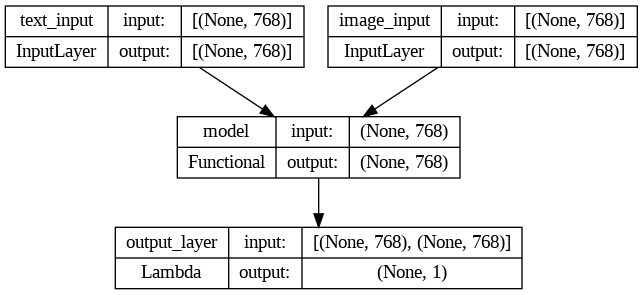

In [ ]:
from tensorflow.keras.utils import plot_model

# Initialize the SiameseModel instance
siamese_model = SiameseModel()

# Build and compile the model
model = siamese_model.initialize_siamese_model()

# Plot the model architecture
plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 768)]                0         []                            
                                                                                                  
 image_input (InputLayer)    [(None, 768)]                0         []                            
                                                                                                  
 model (Functional)          (None, 768)                  590592    ['text_input[0][0]',          
                                                                     'image_input[0][0]']         
                                                                                                  
 output_layer (Lambda)       (None, 1)                    0         ['model[0][0]',   

In [ ]:
print(training_pairs.shape)
print(training_pairs[:,0].shape)
print(training_pairs[:,1].shape)

(31960, 2, 768)
(31960, 768)
(31960, 768)


In [ ]:
# training model
history = model.fit(
    [training_pairs[:,0], training_pairs[:,1]],
    training_labels,
    epochs=100,
    batch_size=10
    ) # 20분

Epoch 1/100
3196/3196 [==============================] - 40s 13ms/step - loss: 0.1889
Epoch 2/100
2432/3196 [=====================>........] - ETA: 9s - loss: 0.1770 

KeyboardInterrupt: 

In [ ]:
# saving model
# model.save('/content/drive/MyDrive/model_save/joint_model', save_format='tf')

# loading saved model
from keras.models import load_model
def contrastive_loss_with_margin(self, y_true, y_pred):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(self.margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

model = load_model('/content/drive/MyDrive/model_save/joint_model', custom_objects={'contrastive_loss_with_margin': contrastive_loss_with_margin})
model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 768)]                0         []                            
                                                                                                  
 image_input (InputLayer)    [(None, 768)]                0         []                            
                                                                                                  
 model (Functional)          (None, 768)                  590592    ['text_input[0][0]',          
                                                                     'image_input[0][0]']         
                                                                                                  
 output_layer (Lambda)       (None, 1)                    0         ['model[0][0]',   

Accuracy check

In [ ]:
# assuming that with a difference less than 0.5 the pair images are the same type
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

y_pred_train = model.predict([training_pairs[:,0], training_pairs[:,1]])
train_accuracy = compute_accuracy(training_labels, y_pred_train)
print("Train Accuracy = {} ".format(train_accuracy))

999/999 [==============================] - 4s 4ms/step
Train Accuracy = 0.8463078848560701 


Model predict(distance) quality check

In [ ]:
# negative pair
pairs = [[word_embedding[5], img_embedding[8]]]
test_pairs = np.array(pairs)

pred = model.predict([test_pairs[:, 0], test_pairs[:,1] ])
pred

1/1 [==============================] - 0s 27ms/step


array([[0.79570234]], dtype=float32)

In [ ]:
# same pair
pairs = [[word_embedding[5], img_embedding[5]]]
test_pairs = np.array(pairs)

pred = model.predict([test_pairs[:, 0], test_pairs[:,1] ])
pred

1/1 [==============================] - 0s 23ms/step


array([[0.5089784]], dtype=float32)

# Inference

In [ ]:
for layer in model.layers:
    print(layer._name)

text_input
image_input
model
output_layer


Build Inference model

In [ ]:
def inference_base():
    input = Input(shape=(768,), name="input")
    output = model.get_layer(name='model')(input)  # get siamese_model layer name
    return Model(inputs=input, outputs=output)

inference_model = inference_base()

In [ ]:
inference_model.trainable = False

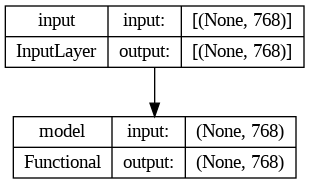

In [ ]:
plot_model(inference_model, show_shapes=True)

In [ ]:
inference_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 model (Functional)          (None, 768)               590592    
                                                                 
Total params: 590592 (2.25 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 590592 (2.25 MB)
_________________________________________________________________


In [ ]:
inference_model.compile()

New vector inference

In [ ]:
new_text_vectors = inference_model.predict(word_embedding)
new_image_vectors = inference_model.predict(img_embedding)

df_embeddings['new_text_vector'] = pd.Series(new_text_vectors.tolist())
df_embeddings['new_image_vector'] = pd.Series(new_image_vectors.tolist())
df_embeddings.head()

531/531 [==============================] - 1s 3ms/step


,text_vector,image_vector,id,new_text_vector,new_image_vector
0,"[-0.010966979898512363, -0.01220102608203888, ...","[0.10158757120370865, 0.0979168638586998, 0.12...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[-0.0339205339550972, 0.03113418072462082, 0.0...","[0.023137016221880913, 0.019032634794712067, 0...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-0.04101037606596947, 0.044144243001937866, -...","[0.008642299100756645, 0.09973420947790146, 0....",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.051304444670677185, 0.021211372688412666, ...","[0.13625210523605347, 0.08245573937892914, 0.0...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.014301798306405544, 0.033127136528491974, ...","[0.0, 0.09222229570150375, 0.02923958562314510...",4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Similarity check after learning

In [ ]:
# before learning
vector_a = np.array(df_embeddings['text_vector'][5])
vector_b = np.array(df_embeddings['image_vector'][5])
ret1 = cosine_similarity([vector_a], [vector_b])
ret2 = euclidean_dist(vector_a, vector_b)
ret3 = euclidean_similarity(vector_a, vector_b)

print(ret1)
print(ret2)
print(ret3)
print('-'*20)

# after learning
vector_a = np.array(df_embeddings['new_text_vector'][5])
vector_b = np.array(df_embeddings['new_image_vector'][5])
ret1 = cosine_similarity([vector_a], [vector_b])
ret2 = euclidean_dist(vector_a, vector_b)
ret3 = euclidean_similarity(vector_a, vector_b)

print(ret1)
print(ret2)
print(ret3)

[[0.02653046]]
1.3953275314834621
0.41747944147775273
--------------------
[[0.75607318]]
0.508978523392782
0.6626999552992998


# Result Check(Query)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tour.csv')
df['filepath'] =0
for i in range(len(df)):
    df['filepath'][i] = '/content/drive/MyDrive/data/image/train/'+ df['id'][i] +'.jpg' # image file path

<ipython-input-18-042d2e7e3f3d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filepath'][i] = '/content/drive/MyDrive/ASAC 기업 프로젝트/data/image/train/'+ df['id'][i] +'.jpg' # image file path


In [ ]:
# multimodal vector 값 df에 통합하여 정리
df_multimodality_embedding = pd.DataFrame(columns=['vector', 'id', 'type'])

df_text = df_embeddings[['new_text_vector', 'id']]
df_image = df_embeddings[['new_image_vector','id']]

df_text.rename(columns = {'new_text_vector' : 'vector'}, inplace = True)
df_image.rename(columns = {'new_image_vector' : 'vector'}, inplace = True)
df_text['type'] = 'text'
df_image['type'] = 'image'

df_multimodality_embedding = pd.concat([df_text,df_image], ignore_index=True)
print(df_multimodality_embedding.shape)
df_multimodality_embedding.tail()

(33972, 3)


<ipython-input-19-d685180b973c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text.rename(columns = {'new_text_vector' : 'vector'}, inplace = True)
<ipython-input-19-d685180b973c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image.rename(columns = {'new_image_vector' : 'vector'}, inplace = True)
<ipython-input-19-d685180b973c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,vector,id,type
33967,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16981,image
33968,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16982,image
33969,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16983,image
33970,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16984,image
33971,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16985,image


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os

def printing_result(query_id):
  # 내가 넣은 쿼리의 이미지 출력
  img_num = str(query_id).zfill(5)
  img_path = f"/content/drive/MyDrive/data/image/train/TRAIN_{img_num}.jpg"
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('off')  # 이미지의 축을 제거하여 깔끔하게 표시
  plt.show()

  ids_list = [ids[0:5], ids[5:10]]
  # 검색 결과 plt 위치에 사진 배치

  plt.fig, axes = plt.subplots(2, 5, figsize=(22, 5))
  for i in range(2):
    for ax, idx in zip(axes[i][0:],ids_list[i]):
      img_num = str(idx).zfill(5)
      image_path = f"/content/drive/MyDrive/data/image/train/TRAIN_{img_num}.jpg"

      img_path = os.path.join(image_path, df.iloc[idx]['filepath'])  # 유사한 이미지의 전체 경로
      img = plt.imread(img_path)
      ax.imshow(img)
      ax.set_title(f'Similar Image {idx}')
      ax.axis('off')


  # df 결과출력
  df2 = pd.DataFrame(columns = df.columns)
  for idx, _ in sorted_dict[:10]:
    id_num = "TRAIN_" + str(idx).zfill(5)
    df2 = pd.concat([df2, df[df['id']==id_num]], ignore_index=True)

  res_cat = df2['cat'].tolist()
  res_cat3 = df2['cat3'].tolist()
  print('cat 출력 결과 :', res_cat)
  display(df2)

  ## 전체 overview text를 읽고 싶다면
  # pd.set_option('display.max_colwidth', None)

1/1 [==============================] - 0s 30ms/step


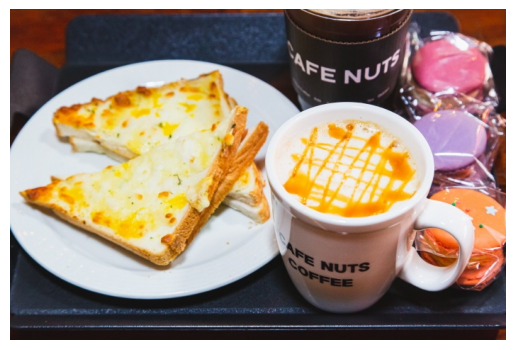

cat 출력 결과 : ['바/까페', '식사류', '바/까페', '바/까페', '바/까페', '바/까페', '바/까페', '바/까페', '바/까페', '한식']


,id,img_path,overview,text,cat1,cat2,cat3,cat,filepath
0,TRAIN_08589,./image/train/TRAIN_08589.jpg,"갓볶은 신선한 원두로 내린 커피와 좋은 재료로 만든 수제마카롱이 있으며, 여러 음료...","갓볶은 신선한 원두로 내린 커피와 좋은 재료로 만든 수제마카롱이 있으며, 여러 음료...",음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
1,TRAIN_01177,./image/train/TRAIN_01177.jpg,루디꼬는 충청남도 부여군 부여읍 쌍북리에 있다. 2022년 8월 현재 부여 최대 규...,루디꼬는 충청남도 부여군 부여읍 쌍북리에 있다. 2022년 8월 현재 부여 최대 규...,음식,음식점,서양식,식사류,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
2,TRAIN_08132,./image/train/TRAIN_08132.jpg,"궁평항과 전곡항, 대부도 가는 길목 송산 나들목 부근에 있는 베이커리 카페이다. ...","궁평항과 전곡항, 대부도 가는 길목 송산 나들목 부근에 있는 베이커리 카페이다. ...",음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
3,TRAIN_11080,./image/train/TRAIN_11080.jpg,좋은아침페스츄리 신정호수점은 충남 아산시 기산동에 있다.\n대표 메뉴는 각종 베이커...,좋은아침페스츄리 신정호수점은 충남 아산시 기산동에 있다.대표 메뉴는 각종 베이커리다...,음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
4,TRAIN_05911,./image/train/TRAIN_05911.jpg,서울특별시 종로에 있는 카페이다. 와플 전문점이다. 대표메뉴는 와플이다.,서울특별시 종로에 있는 카페이다. 와플 전문점이다. 대표메뉴는 와플이다.,음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
5,TRAIN_02361,./image/train/TRAIN_02361.jpg,부바스는 대구시 수성구 두산동에 자리 잡고 있다. 대표 메뉴는 '마약 옥수수'란 별...,부바스는 대구시 수성구 두산동에 자리 잡고 있다. 대표 메뉴는 '마약 옥수수'란 별...,음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
6,TRAIN_05975,./image/train/TRAIN_05975.jpg,카페화담은 경북 구미시 오태동에 있다.<br>대표 메뉴는 아메리카노다. 이 밖에 바...,카페화담은 경북 구미시 오태동에 있다.대표 메뉴는 아메리카노다. 이 밖에 바닐라라뗴...,음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
7,TRAIN_15315,./image/train/TRAIN_15315.jpg,핀스커피는 충청남도 천안시 동남구 구성동에 있다. 탁 트인 공간에 있는 모던한 느낌...,핀스커피는 충청남도 천안시 동남구 구성동에 있다. 탁 트인 공간에 있는 모던한 느낌...,음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
8,TRAIN_11646,./image/train/TRAIN_11646.jpg,해운대 달맞이고개에 위치한 한국 전통찻집 비비비당은 한눈에 펼쳐지는 바다 전망과 한...,해운대 달맞이고개에 위치한 한국 전통찻집 비비비당은 한눈에 펼쳐지는 바다 전망과 한...,음식,음식점,바/까페,바/까페,/content/drive/MyDrive/ASAC 기업 프로젝트/da...
9,TRAIN_15609,./image/train/TRAIN_15609.jpg,조개구이를 전문으로 하는 ‘우리 이모집’은 영도의 아름다운 바다와 함께 싱싱한 조개...,조개구이를 전문으로 하는 ‘우리 이모집’은 영도의 아름다운 바다와 함께 싱싱한 조개...,음식,음식점,한식,한식,/content/drive/MyDrive/ASAC 기업 프로젝트/da...


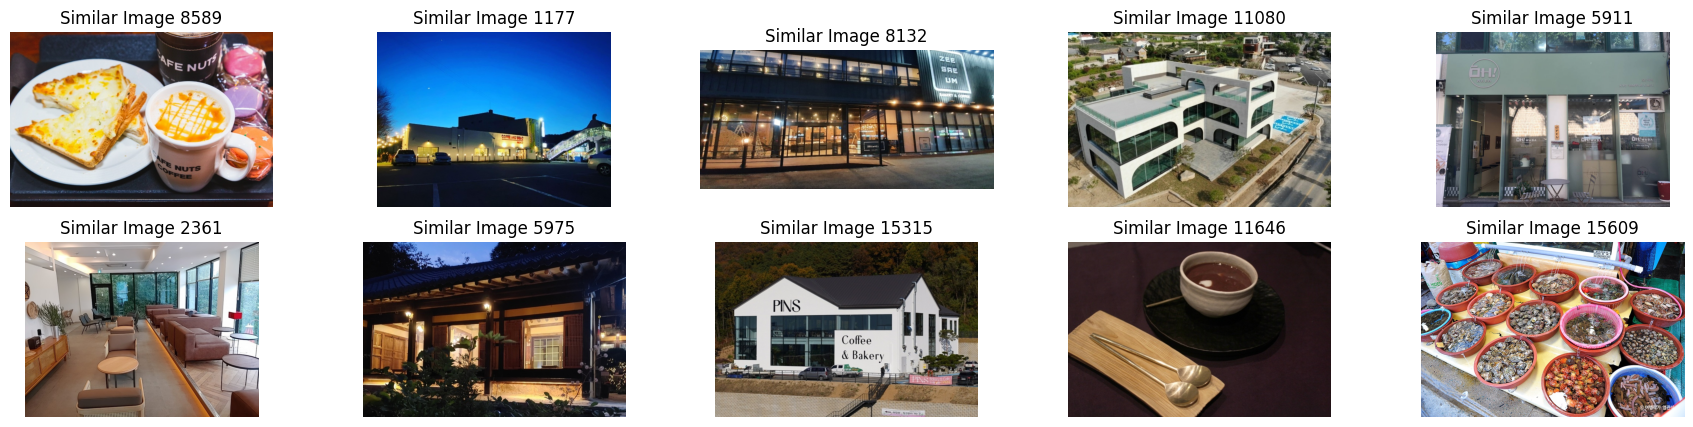

In [ ]:
# 질문
query_id = 8589   ### 쿼리 번호만 변경해서 집어넣으세요.
a = word_embedding[query_id].reshape(1,-1) # (1, 768)     ## 쿼리 type에 따라 word_embedding, img_embedding 설정

# 벡터 임베딩
query_text_vectors = inference_model.predict(a) # (1, 768)

idx_dict = {}
for i in range(len(df_embeddings)):
  vector_a = [np.array(df_embeddings['new_text_vector'][i])]    ## 비교할 벡터 데이터 new_image_vector, new_text_vector 설정
  vector_b = [query_text_vectors[0]] # input data type
  ret = cosine_similarity(vector_a, vector_b)
  idx_dict[i] = ret

sorted_dict = sorted(idx_dict.items(), key=lambda x: -x[1])
ids = []
for key, value in sorted_dict[:10]:
  ids.append(key)
  # print(key, value)

# 이미지, 텍스트 결과 모두 보기
printing_result(query_id)

# Model Evaulation

### Loading word embedding model and image embedding model

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
from sentence_transformers import SentenceTransformer

# 모델을 불러올 경로 지정
model_path = "/content/drive/MyDrive/model_save/SBERT_model"
# 저장된 모델 불러오기
model_SBERT = SentenceTransformer(model_path)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### model evaulation

In [ ]:
import warnings

# 경고 무시
warnings.filterwarnings("ignore")

chechking acc, and weighted precision with word embedding model

In [ ]:
def weighted_avg_precision(tot_pred_labels, true_label):
  total_precision = 0
  weights = [10/55, 9/55, 8/55, 7/55, 6/55, 5/55, 4/55, 3/55, 2/55, 1/55]

  tot_correct_scores = [1 if tot_pred_labels[i] == true_label else 0 for i in range(len(tot_pred_labels))]
  tot_precision = sum([tot_correct_scores[i] * weights[i] for i in range(len(tot_pred_labels))])
  print('전체데이터 acc : ', sum(tot_correct_scores) / 10)
  print(f'전체데이터 맞춘 개수 : {sum(tot_correct_scores)}', f' / 정오표 : {tot_correct_scores}')
  print(f'전체데이터 가중치 평균 값 : {round(tot_precision, 3)}')

query_id_list = [1, 8589, 10787, 21, 66, 16961, 9, 12903, 11367]
df_embeddings['image_search_similarity'] = 0

for query_id in query_id_list:
  print(query_id)
  img_emb = img_embedding[query_id].reshape(1,-1)

  for i in range(len(df_embeddings)):
    vector_a = [np.array(df_embeddings['image_vector'][i])]  ## 비교할 벡터 데이터 new_image_vector, new_text_vector 설정
    vector_b = np.array(img_emb)
    ret = cosine_similarity(vector_a, vector_b)
    df_embeddings['image_search_similarity'][i] = ret

  df_embeddings.sort_values(by=['image_search_similarity'], ascending=False, inplace=True)
  display(df_embeddings.head(2))

  query = df.iloc[query_id]['overview']
  print(f'query : {query}')
  true_label = df.iloc[query_id]['cat']
  print(f'true label : {true_label}')
  print()

  tot_pred_labels = []
  avg_similarity = 0
  for ranks in range(10):
    id_ = df_embeddings.iloc[ranks]['id']
    avg_similarity += df_embeddings.iloc[ranks]['image_search_similarity']
    ans = df.iloc[id_]['cat']
    tot_pred_labels.append(ans)
  print('이미지-이미지 검색 성능 결과')
  print(tot_pred_labels)
  print(f'평균 유사도 : {round(avg_similarity/10, 5)}')
  weighted_avg_precision(tot_pred_labels, true_label)
  print()

1


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
1,"[-0.0339205339550972, 0.03113418072462082, 0.0...","[0.023137016221880913, 0.019032634794712067, 0...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.132810
1176,"[-0.017865614965558052, 0.053946830332279205, ...","[0.043382611125707626, 0.01342036109417677, 0....",1176,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.778196,0.324003


query : 경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 2016년 대중제로 전환하여 재개장했다. 총 부지 약 980,,000㎡에 전장 6,607m에 18홀 파 72이다. Lake 코스와 Mountain 코스가 있다. 미국 100대 골프 코스 설계자인 짐 파지오가 아마추어에게는 쉽고 프로골퍼에게는 어렵게 설계했다고 한다. 가까이에 뉴스프링빌CC, 써닝포인트CC, 비에이비스타CC, 덕평CC 등의 골프장이 있다.
true label : 레포츠

이미지-이미지 검색 성능 결과
['레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠']
평균 유사도 : 0.75499
전체데이터 acc :  1.0
전체데이터 맞춘 개수 : 10  / 정오표 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
전체데이터 가중치 평균 값 : 1.0

8589


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
8589,"[-0.017623376101255417, 0.02215953916311264, 0...","[0.028341850265860558, 0.04630178585648537, 0....",8589,"[0.45933985710144043, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.7031838893890381, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.221729
11239,"[-0.0636979192495346, 0.05578988790512085, -0....","[0.01149335689842701, 0.070309579372406, 0.055...",11239,"[0.16647088527679443, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.773111,0.459394


query : 갓볶은 신선한 원두로 내린 커피와 좋은 재료로 만든 수제마카롱이 있으며, 여러 음료와 간식이 준비되어 있는 장평터미널 앞 카페이다.
true label : 바/까페

이미지-이미지 검색 성능 결과
['바/까페', '한식', '바/까페', '식사류', '바/까페', '식사류', '식사류', '한식', '바/까페', '한식']
평균 유사도 : 0.77337
전체데이터 acc :  0.4
전체데이터 맞춘 개수 : 4  / 정오표 : [1, 0, 1, 0, 1, 0, 0, 0, 1, 0]
전체데이터 가중치 평균 값 : 0.473

10787


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
10787,"[-0.046061813831329346, 0.0469541996717453, -0...","[0.09959738701581955, 0.09727353602647781, 0.0...",10787,"[0.5663824081420898, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4854419231414795, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.439140
811,"[-0.05203622207045555, -0.018060974776744843, ...","[0.14275383949279785, 0.05645481124520302, 0.0...",811,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.665797,0.333169


query : 오창카페식물원은 카페 이름처럼 작은 식물원을 연상시키는 곳이다. 카페 공간 어느 곳이든 마치 식물원에 앉아있는 느낌이다. 실내 곳곳에 싱그러운 식물이 빼곡하다. 그래서 카페 안에서 커피 향을 맡을 수 없다. 여러 식물들이 공기 정화 작용을 하기 때문이다. 이곳에서는 아메리카노를 비롯해 플랫화이트, 아인슈페너 등을 맛볼 수 있으며, 식물도 함께 판매하고 있다.
true label : 바/까페

이미지-이미지 검색 성능 결과
['바/까페', '숙박', '숙박', '숙박', '숙박', '바/까페', '숙박', '숙박', '숙박', '숙박']
평균 유사도 : 0.68007
전체데이터 acc :  0.2
전체데이터 맞춘 개수 : 2  / 정오표 : [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
전체데이터 가중치 평균 값 : 0.273

21


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
21,"[-0.01240366417914629, 0.012438086792826653, 0...","[0.11088377982378006, 0.05838177353143692, 0.0...",21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.552697
5245,"[-0.022621100768446922, 0.010256378911435604, ...","[0.11586625128984451, 0.023326950147747993, 0....",5245,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.736427,0.533991


query : 전남 여수시에 위치한 트윈스모텔은 창문마다 작은 테라스가 달려있어 귀여운 느낌의 건물이다. 아기자기한 화분이 있는 정문을 지나 내부로 들어서면 플라워 패턴의 벽지가 화사하고 아늑한 온돌 방과 화려한 원형 침대가 있는 침대방이 편안해 보인다. 방마다 창문이 있어 햇빛이 잘 들어 낮에도 휴식하기에 좋다. TV, 에어컨, 컴퓨터, 미니 냉장고, 화장대 등의 편의 시설이 잘 되어 있다. 화장실이 청결하게 되어 있고, 욕조가 있어 목욕이 가능하다.
true label : 숙박

이미지-이미지 검색 성능 결과
['숙박', '숙박', '숙박', '숙박', '한식', '휴양/체험/산업관광지', '숙박', '숙박', '숙박', '한식']
평균 유사도 : 0.74047
전체데이터 acc :  0.7
전체데이터 맞춘 개수 : 7  / 정오표 : [1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
전체데이터 가중치 평균 값 : 0.782

66


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
66,"[-0.0639357939362526, 0.005660634953528643, 0....","[0.06143152713775635, 0.036750853061676025, 0....",66,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.00000,0.385025
8581,"[-0.03896937146782875, -0.03576717898249626, 0...","[0.04089948534965515, 0.0, 0.05073594674468040...",8581,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0058699846267700195, 0.0, 0.0, 0.0, 0.0, 0....",0.66042,0.377992


query : 에메랄드 빛 바다와 천혜의 경관을 그대로 마주하고 있는 그랜드 조선 제주는 제주 대표 관광지가 모여있는 중문관광단지에 위치하여 풍부한 주변 볼거리를 제공한다.  제주의 바다를 닮은 넓고 고요한 객실은 일상을 벗어난 편안한 여유의 시간을 즐기기에 최적의 공간이다. 특히, 그랜드 조선 힐 스위트는 완벽한 공간분리를 통해 오직 서로에게만 집중하고 싶은 허니무너들에게 가장 달콤하고 프라이빗한 시간을 선사한다. 미식의 즐거움을 책임지는 6개의 레스토랑 & 바 그리고 사계절 온수풀, 피트니스, 스파, 키즈클럽까지 다양한 서비스와 컨텐츠를 통해 즐거움으로 가득찬 여정을 선사한다.
true label : 숙박

이미지-이미지 검색 성능 결과
['숙박', '식사류', '숙박', '바/까페', '레포츠', '문화시설/건축/조형물', '한식', '문화시설/건축/조형물', '문화시설/건축/조형물', '숙박']
평균 유사도 : 0.68144
전체데이터 acc :  0.3
전체데이터 맞춘 개수 : 3  / 정오표 : [1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
전체데이터 가중치 평균 값 : 0.345

16961


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
16961,"[-0.06359560787677765, 0.009620320983231068, 0...","[0.0695200115442276, 0.05677981674671173, 0.05...",16961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.258945
5579,"[-0.05498628690838814, 0.023742061108350754, 0...","[0.08933226019144058, 0.1449628621339798, 0.06...",5579,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.720769,0.258598


query : 제주시 탑동 해변가에 아늑한 남국의 정취를 맞이하며 서 있는 제주오리엔탈호텔은 다양한 객실과 500명의 국내/외 세미나를 동시에 개최할 수 있는 대연회장과 3개소의 중소형 연회장, 그리고 각종 레스토랑과 사우나 시설을 갖추고 있다. 제주오리엔탈호텔은 리조트 고객과 비즈니스 고객을 위한 최적의 장소, 최고의 시설을 갖추고 있다.또한 제주 국제공항과 4Km 이내의 거리에 위치하고 있어 매우 편리한 교통을 자랑하며 제주시 중심가에 자리하고 있어 쇼핑은 물론 먹을거리, 즐길 거리 등이 있다. 호텔 바로 앞 탑동 해변가를 따라 산책로와 공원이 조성되어 있어 새벽 조깅 및 산책이 가능하고 호텔에서 서쪽으로 10분 정도의 거리에 있는 용두암 및 해안도로와 카페촌은 최적의 드라이브 장소와 데이트 코스로 손꼽히고 있다. 호텔 바로 옆으로는 횟집과 토속음식점들이 즐비하게 늘어서 있어 제주의 맛과 멋을 풍기며 미식가들의 환영을 받고 있다.호텔 내의 부대시설로는 비즈니스센터, 카지노, 커피숍, 로비라운지, BAR 등이 마련되어 있으며 설비와 고객의 취향을 만족시켜주는 최상의 서비스를 통해 편안하고 안락하게 지내실 수 있도록 모든 편의를 제공하고 있다.
true label : 숙박

이미지-이미지 검색 성능 결과
['숙박', '숙박', '휴양/체험/산업관광지', '문화시설/건축/조형물', '휴양/체험/산업관광지', '숙박', '숙박', '문화시설/건축/조형물', '숙박', '한식']
평균 유사도 : 0.7262
전체데이터 acc :  0.5
전체데이터 맞춘 개수 : 5  / 정오표 : [1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
전체데이터 가중치 평균 값 : 0.545

9


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
9,"[-0.03395942971110344, -0.024369006976485252, ...","[0.099839948117733, 0.09066597372293472, 0.0, ...",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.142130
16870,"[-0.05003245919942856, -0.024776238948106766, ...","[0.10889328271150589, 0.0, 0.03122449107468128...",16870,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.781363,0.116585


query : 2020년 한국소비자 평가 최고의 브랜드 대상을 수상한 대한민국 명품쌀 문막농협 원주쌀 토토미와 청정지역 강원도의 대표 먹거리 옥수수를 직거래 및 온라인 행사를 통해 홍보하고 판매하여 농가에 도움을 주는 지역의 대표 축제이다.축제기간은 7.8~7.10까지 3일간이다. (매년 날짜는 조금씩 차이가 있다.)온라인 할인 행사기간은 7월1일 ~ 7월 29일까지 약 한달간이며, 전국 택배서비스를 실시한다.농민들의 정성이 담긴 다양한 농산물들을 직접 만날수 있는 장터이다.(품목안내 : 옥수수, 토토미, 논마늘, 수박, 토마토, 감자, 고구마, 부추 등 농산물)
true label : 축제/공연/행사

이미지-이미지 검색 성능 결과
['축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사']
평균 유사도 : 0.77523
전체데이터 acc :  1.0
전체데이터 맞춘 개수 : 10  / 정오표 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
전체데이터 가중치 평균 값 : 1.0

12903


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
12903,"[-0.023458994925022125, 0.03533422574400902, 0...","[0.13600777089595795, 0.0, 0.083851158618927, ...",12903,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,0.237925
15570,"[0.031213775277137756, 0.025286508724093437, 0...","[0.13903947174549103, 0.00972385797649622, 0.0...",15570,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.807007,0.032387


query : 고려 공민왕 2년(1385년)에 진정국사가 약사절 창건하였다. 조선말 고종황제께서 불국정토를 이루자는 뜻에서 불국사란 사명을 내렸고,한국전쟁으로 약사 부처님만 남고 사찰 소실되어 1964년 풍곡화상이 중창하였다.
true label : 역사관광지

이미지-이미지 검색 성능 결과
['역사관광지', '역사관광지', '역사관광지', '역사관광지', '역사관광지', '역사관광지', '문화시설/건축/조형물', '역사관광지', '문화시설/건축/조형물', '역사관광지']
평균 유사도 : 0.81232
전체데이터 acc :  0.8
전체데이터 맞춘 개수 : 8  / 정오표 : [1, 1, 1, 1, 1, 1, 0, 1, 0, 1]
전체데이터 가중치 평균 값 : 0.891

11367


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
11367,"[-0.04987643286585808, 0.037809018045663834, 0...","[0.045431189239025116, 0.14445079863071442, 0....",11367,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1.000000
15461,"[-0.0014303517527878284, 0.020606257021427155,...","[0.03554081916809082, 0.08756635338068008, 0.0...",15461,"[0.04641115665435791, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.670054,0.183375


query : 온양관광호텔의 온천수는 마니타온을 함유한 랴듐온천으로 온천공에서 직접 공급되는 57℃의 고열온천으로 약아라리성 온천수이다. 온천수의 주요 성분은 칼슘, 라듐, 마그네슘 등의 성분이 골고루 함유되어 있으며 온천수의 주요 효능으로는 피부노화 방지 및 갱년기 장애예방, 당뇨병의 예방과 치유, 항암과 암치료, 피로회복 및 스트레스 해소, 위장병 치유, 성인병 예방과 치유, 신경통, 류마티스, 습진, 피부병, 냉증, 부인병 등의 좋다.
true label : 휴양/체험/산업관광지

이미지-이미지 검색 성능 결과
['휴양/체험/산업관광지', '문화시설/건축/조형물', '문화시설/건축/조형물', '숙박', '한식', '한식', '휴양/체험/산업관광지', '문화시설/건축/조형물', '문화시설/건축/조형물', '레포츠']
평균 유사도 : 0.6938
전체데이터 acc :  0.2
전체데이터 맞춘 개수 : 2  / 정오표 : [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
전체데이터 가중치 평균 값 : 0.255



chechking acc, and weighted precision with image embedding model

In [ ]:
def weighted_avg_precision(tot_pred_labels, true_label):
  total_precision = 0
  weights = [10/55, 9/55, 8/55, 7/55, 6/55, 5/55, 4/55, 3/55, 2/55, 1/55]

  tot_correct_scores = [1 if tot_pred_labels[i] == true_label else 0 for i in range(len(tot_pred_labels))]
  tot_precision = sum([tot_correct_scores[i] * weights[i] for i in range(len(tot_pred_labels))])
  print('전체데이터 acc : ', sum(tot_correct_scores) / 10)
  print(f'전체데이터 맞춘 개수 : {sum(tot_correct_scores)}', f' / 정오표 : {tot_correct_scores}')
  print(f'전체데이터 가중치 평균 값 : {round(tot_precision, 3)}')

query_id_list = [1, 8589, 10787, 21, 66, 16961, 9, 12903, 11367]
df_embeddings['text_search_similarity'] = 0

for query_id in query_id_list:
  print(query_id)
  word_emb = word_embedding[query_id].reshape(1,-1)

  for i in range(len(df_embeddings)):
    vector_a = [np.array(df_embeddings['text_vector'][i])]  ## 비교할 벡터 데이터 new_image_vector, new_text_vector 설정
    vector_b = np.array(word_emb)
    ret = cosine_similarity(vector_a, vector_b)
    df_embeddings['text_search_similarity'][i] = ret

  df_embeddings.sort_values(by=['text_search_similarity'], ascending=False, inplace=True)
  display(df_embeddings.head(2))

  query = df.iloc[query_id]['overview']
  print(f'query : {query}')
  true_label = df.iloc[query_id]['cat']
  print(f'true label : {true_label}')
  print()

  tot_pred_labels = []
  avg_similarity = 0
  for ranks in range(10):
    id_ = df_embeddings.iloc[ranks]['id']
    avg_similarity += df_embeddings.iloc[ranks]['text_search_similarity']
    ans = df.iloc[id_]['cat']
    tot_pred_labels.append(ans)
  print('텍스트-텍스트 검색 성능 결과')
  print(tot_pred_labels)
  print(f'평균 유사도 : {round(avg_similarity/10, 5)}')
  weighted_avg_precision(tot_pred_labels, true_label)
  print()

1


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
1,"[-0.0339205339550972, 0.03113418072462082, 0.0...","[0.023137016221880913, 0.019032634794712067, 0...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.471048,1.000000
5368,"[-0.02065696381032467, 0.019658735021948814, 0...","[0.055084146559238434, 0.025737501680850983, 0...",5368,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.490200,0.777268


query : 경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 2016년 대중제로 전환하여 재개장했다. 총 부지 약 980,,000㎡에 전장 6,607m에 18홀 파 72이다. Lake 코스와 Mountain 코스가 있다. 미국 100대 골프 코스 설계자인 짐 파지오가 아마추어에게는 쉽고 프로골퍼에게는 어렵게 설계했다고 한다. 가까이에 뉴스프링빌CC, 써닝포인트CC, 비에이비스타CC, 덕평CC 등의 골프장이 있다.
true label : 레포츠

텍스트-텍스트 검색 성능 결과
['레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠']
평균 유사도 : 0.78333
전체데이터 acc :  1.0
전체데이터 맞춘 개수 : 10  / 정오표 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
전체데이터 가중치 평균 값 : 1.0

8589


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
8589,"[-0.017623376101255417, 0.02215953916311264, 0...","[0.028341850265860558, 0.04630178585648537, 0....",8589,"[0.45933985710144043, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.7031838893890381, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.411630,1.000000
7737,"[-0.05889434367418289, 0.048448219895362854, -...","[0.005940015893429518, 0.1005573645234108, 0.0...",7737,"[0.6853799819946289, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5871511697769165, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.439312,0.854282


query : 갓볶은 신선한 원두로 내린 커피와 좋은 재료로 만든 수제마카롱이 있으며, 여러 음료와 간식이 준비되어 있는 장평터미널 앞 카페이다.
true label : 바/까페

텍스트-텍스트 검색 성능 결과
['바/까페', '바/까페', '바/까페', '바/까페', '한식', '바/까페', '바/까페', '바/까페', '바/까페', '한식']
평균 유사도 : 0.85312
전체데이터 acc :  0.8
전체데이터 맞춘 개수 : 8  / 정오표 : [1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
전체데이터 가중치 평균 값 : 0.873

10787


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
10787,"[-0.046061813831329346, 0.0469541996717453, -0...","[0.09959738701581955, 0.09727353602647781, 0.0...",10787,"[0.5663824081420898, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4854419231414795, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.599901,1.000000
4106,"[-0.061936043202877045, -0.0018370465841144323...","[0.01019820012152195, 0.04588491469621658, 0.1...",4106,"[0.5185781717300415, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.533902645111084, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",0.502620,0.830824


query : 오창카페식물원은 카페 이름처럼 작은 식물원을 연상시키는 곳이다. 카페 공간 어느 곳이든 마치 식물원에 앉아있는 느낌이다. 실내 곳곳에 싱그러운 식물이 빼곡하다. 그래서 카페 안에서 커피 향을 맡을 수 없다. 여러 식물들이 공기 정화 작용을 하기 때문이다. 이곳에서는 아메리카노를 비롯해 플랫화이트, 아인슈페너 등을 맛볼 수 있으며, 식물도 함께 판매하고 있다.
true label : 바/까페

텍스트-텍스트 검색 성능 결과
['바/까페', '바/까페', '바/까페', '바/까페', '한식', '한식', '바/까페', '바/까페', '바/까페', '휴양/체험/산업관광지']
평균 유사도 : 0.80998
전체데이터 acc :  0.7
전체데이터 맞춘 개수 : 7  / 정오표 : [1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
전체데이터 가중치 평균 값 : 0.782

21


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
21,"[-0.01240366417914629, 0.012438086792826653, 0...","[0.11088377982378006, 0.05838177353143692, 0.0...",21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.467045,1.000000
15034,"[-0.02255801483988762, 0.032737039029598236, 0...","[0.1739039123058319, 0.01326033566147089, 0.02...",15034,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.490391,0.876229


query : 전남 여수시에 위치한 트윈스모텔은 창문마다 작은 테라스가 달려있어 귀여운 느낌의 건물이다. 아기자기한 화분이 있는 정문을 지나 내부로 들어서면 플라워 패턴의 벽지가 화사하고 아늑한 온돌 방과 화려한 원형 침대가 있는 침대방이 편안해 보인다. 방마다 창문이 있어 햇빛이 잘 들어 낮에도 휴식하기에 좋다. TV, 에어컨, 컴퓨터, 미니 냉장고, 화장대 등의 편의 시설이 잘 되어 있다. 화장실이 청결하게 되어 있고, 욕조가 있어 목욕이 가능하다.
true label : 숙박

텍스트-텍스트 검색 성능 결과
['숙박', '숙박', '숙박', '숙박', '숙박', '숙박', '숙박', '숙박', '숙박', '숙박']
평균 유사도 : 0.86117
전체데이터 acc :  1.0
전체데이터 맞춘 개수 : 10  / 정오표 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
전체데이터 가중치 평균 값 : 1.0

66


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
66,"[-0.0639357939362526, 0.005660634953528643, 0....","[0.06143152713775635, 0.036750853061676025, 0....",66,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.588135,1.000000
4635,"[-0.06562579423189163, 0.008448060601949692, 0...","[0.10047042369842529, 0.059815663844347, 0.073...",4635,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.451427,0.922793


query : 에메랄드 빛 바다와 천혜의 경관을 그대로 마주하고 있는 그랜드 조선 제주는 제주 대표 관광지가 모여있는 중문관광단지에 위치하여 풍부한 주변 볼거리를 제공한다.  제주의 바다를 닮은 넓고 고요한 객실은 일상을 벗어난 편안한 여유의 시간을 즐기기에 최적의 공간이다. 특히, 그랜드 조선 힐 스위트는 완벽한 공간분리를 통해 오직 서로에게만 집중하고 싶은 허니무너들에게 가장 달콤하고 프라이빗한 시간을 선사한다. 미식의 즐거움을 책임지는 6개의 레스토랑 & 바 그리고 사계절 온수풀, 피트니스, 스파, 키즈클럽까지 다양한 서비스와 컨텐츠를 통해 즐거움으로 가득찬 여정을 선사한다.
true label : 숙박

텍스트-텍스트 검색 성능 결과
['숙박', '숙박', '숙박', '숙박', '숙박', '숙박', '숙박', '숙박', '휴양/체험/산업관광지', '숙박']
평균 유사도 : 0.89589
전체데이터 acc :  0.9
전체데이터 맞춘 개수 : 9  / 정오표 : [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
전체데이터 가중치 평균 값 : 0.964

16961


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
16961,"[-0.06359560787677765, 0.009620320983231068, 0...","[0.0695200115442276, 0.05677981674671173, 0.05...",16961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.451151,1.000000
12251,"[-0.034670278429985046, 0.011335190385580063, ...","[0.10176127403974533, 0.00014981624553911388, ...",12251,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.460586,0.836949


query : 제주시 탑동 해변가에 아늑한 남국의 정취를 맞이하며 서 있는 제주오리엔탈호텔은 다양한 객실과 500명의 국내/외 세미나를 동시에 개최할 수 있는 대연회장과 3개소의 중소형 연회장, 그리고 각종 레스토랑과 사우나 시설을 갖추고 있다. 제주오리엔탈호텔은 리조트 고객과 비즈니스 고객을 위한 최적의 장소, 최고의 시설을 갖추고 있다.또한 제주 국제공항과 4Km 이내의 거리에 위치하고 있어 매우 편리한 교통을 자랑하며 제주시 중심가에 자리하고 있어 쇼핑은 물론 먹을거리, 즐길 거리 등이 있다. 호텔 바로 앞 탑동 해변가를 따라 산책로와 공원이 조성되어 있어 새벽 조깅 및 산책이 가능하고 호텔에서 서쪽으로 10분 정도의 거리에 있는 용두암 및 해안도로와 카페촌은 최적의 드라이브 장소와 데이트 코스로 손꼽히고 있다. 호텔 바로 옆으로는 횟집과 토속음식점들이 즐비하게 늘어서 있어 제주의 맛과 멋을 풍기며 미식가들의 환영을 받고 있다.호텔 내의 부대시설로는 비즈니스센터, 카지노, 커피숍, 로비라운지, BAR 등이 마련되어 있으며 설비와 고객의 취향을 만족시켜주는 최상의 서비스를 통해 편안하고 안락하게 지내실 수 있도록 모든 편의를 제공하고 있다.
true label : 숙박

텍스트-텍스트 검색 성능 결과
['숙박', '숙박', '숙박', '숙박', '휴양/체험/산업관광지', '숙박', '숙박', '숙박', '숙박', '숙박']
평균 유사도 : 0.82855
전체데이터 acc :  0.9
전체데이터 맞춘 개수 : 9  / 정오표 : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
전체데이터 가중치 평균 값 : 0.891

9


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
9,"[-0.03395942971110344, -0.024369006976485252, ...","[0.099839948117733, 0.09066597372293472, 0.0, ...",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.476315,1.00000
1331,"[-0.04276490584015846, -0.03941000625491142, 0...","[0.026749901473522186, 0.21459276974201202, 0....",1331,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.434985,0.88848


query : 2020년 한국소비자 평가 최고의 브랜드 대상을 수상한 대한민국 명품쌀 문막농협 원주쌀 토토미와 청정지역 강원도의 대표 먹거리 옥수수를 직거래 및 온라인 행사를 통해 홍보하고 판매하여 농가에 도움을 주는 지역의 대표 축제이다.축제기간은 7.8~7.10까지 3일간이다. (매년 날짜는 조금씩 차이가 있다.)온라인 할인 행사기간은 7월1일 ~ 7월 29일까지 약 한달간이며, 전국 택배서비스를 실시한다.농민들의 정성이 담긴 다양한 농산물들을 직접 만날수 있는 장터이다.(품목안내 : 옥수수, 토토미, 논마늘, 수박, 토마토, 감자, 고구마, 부추 등 농산물)
true label : 축제/공연/행사

텍스트-텍스트 검색 성능 결과
['축제/공연/행사', '축제/공연/행사', '문화시설/건축/조형물', '휴양/체험/산업관광지', '한식', '축제/공연/행사', '축제/공연/행사', '축제/공연/행사', '한식', '휴양/체험/산업관광지']
평균 유사도 : 0.89308
전체데이터 acc :  0.5
전체데이터 맞춘 개수 : 5  / 정오표 : [1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
전체데이터 가중치 평균 값 : 0.564

12903


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
12903,"[-0.023458994925022125, 0.03533422574400902, 0...","[0.13600777089595795, 0.0, 0.083851158618927, ...",12903,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.453953,1.000000
15230,"[-0.03966346010565758, 0.027159320190548897, 0...","[0.11375027149915695, 0.02056300640106201, 0.0...",15230,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.499083,0.761478


query : 고려 공민왕 2년(1385년)에 진정국사가 약사절 창건하였다. 조선말 고종황제께서 불국정토를 이루자는 뜻에서 불국사란 사명을 내렸고,한국전쟁으로 약사 부처님만 남고 사찰 소실되어 1964년 풍곡화상이 중창하였다.
true label : 역사관광지

텍스트-텍스트 검색 성능 결과
['역사관광지', '역사관광지', '휴양/체험/산업관광지', '역사관광지', '역사관광지', '역사관광지', '역사관광지', '역사관광지', '역사관광지', '역사관광지']
평균 유사도 : 0.76133
전체데이터 acc :  0.9
전체데이터 맞춘 개수 : 9  / 정오표 : [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
전체데이터 가중치 평균 값 : 0.855

11367


,text_vector,image_vector,id,new_text_vector,new_image_vector,image_search_similarity,text_search_similarity
11367,"[-0.04987643286585808, 0.037809018045663834, 0...","[0.045431189239025116, 0.14445079863071442, 0....",11367,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1.000000
9556,"[-0.04976924881339073, 0.06020443141460419, 0....","[0.03911544010043144, 0.003715499769896269, 0....",9556,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.558217,0.875399


query : 온양관광호텔의 온천수는 마니타온을 함유한 랴듐온천으로 온천공에서 직접 공급되는 57℃의 고열온천으로 약아라리성 온천수이다. 온천수의 주요 성분은 칼슘, 라듐, 마그네슘 등의 성분이 골고루 함유되어 있으며 온천수의 주요 효능으로는 피부노화 방지 및 갱년기 장애예방, 당뇨병의 예방과 치유, 항암과 암치료, 피로회복 및 스트레스 해소, 위장병 치유, 성인병 예방과 치유, 신경통, 류마티스, 습진, 피부병, 냉증, 부인병 등의 좋다.
true label : 휴양/체험/산업관광지

텍스트-텍스트 검색 성능 결과
['휴양/체험/산업관광지', '휴양/체험/산업관광지', '휴양/체험/산업관광지', '휴양/체험/산업관광지', '레포츠', '휴양/체험/산업관광지', '휴양/체험/산업관광지', '휴양/체험/산업관광지', '숙박', '휴양/체험/산업관광지']
평균 유사도 : 0.82721
전체데이터 acc :  0.8
전체데이터 맞춘 개수 : 8  / 정오표 : [1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
전체데이터 가중치 평균 값 : 0.855



chechking acc, and weighted precision with Multimodal model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tour.csv')
df.head(2)

,id,img_path,overview,cat1,cat2,cat3,cat
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구,자연
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프,레포츠


In [ ]:
df_multimodality_embedding['text_search_similarity'] = 0
df_multimodality_embedding['image_search_similarity'] = 0
df_multimodality_embedding.head(2)

,vector,id,type,text_search_similarity,image_search_similarity
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,text,0,0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,text,0,0


In [ ]:
def weighted_avg_precision(tot_pred_labels, true_label):
  total_precision = 0
  weights = [10/55, 9/55, 8/55, 7/55, 6/55, 5/55, 4/55, 3/55, 2/55, 1/55]

  tot_correct_scores = [1 if tot_pred_labels[i] == true_label else 0 for i in range(len(tot_pred_labels))]
  tot_precision = sum([tot_correct_scores[i] * weights[i] for i in range(len(tot_pred_labels))])
  print('전체데이터 acc : ', sum(tot_correct_scores) / 10)
  print(f'전체데이터 맞춘 개수 : {sum(tot_correct_scores)}', f' / 정오표 : {tot_correct_scores}')
  print(f'전체데이터 가중치 평균 값 : {round(tot_precision, 3)}')

def checking_score(query_id):
  query = df.iloc[query_id]['overview']
  print(f'query : {query}')
  true_label = df.iloc[query_id]['cat']
  print(f'true label : {true_label}')

  word_emb = word_embedding[query_id].reshape(1,-1) # (1, 768)
  img_emb = img_embedding[query_id].reshape(1,-1)

  # 벡터 임베딩
  query_text_vectors = inference_model.predict(word_emb)
  query_image_vectors = inference_model.predict(img_emb)

  idx_dict = {}
  for i in range(len(df_multimodality_embedding)):
    vector_1 = [query_text_vectors[0]]
    vector_2 = [query_image_vectors[0]]

    vector_a = [np.array(df_multimodality_embedding['vector'][i])]    ## 비교할 벡터 데이터 new_image_vector, new_text_vector 설정
    ret1 = cosine_similarity(vector_a, vector_1)
    ret2 = cosine_similarity(vector_a, vector_2)
    df_multimodality_embedding['text_search_similarity'][i] = round(ret1[0][0],5)
    df_multimodality_embedding['image_search_similarity'][i] = round(ret2[0][0],5)

  # 이미지, 텍스트 결과 모두 보기
  tot_pred_labels = []
  avg_cos_sim = 0
  df_multimodality_embedding.sort_values(by=['text_search_similarity'], ascending=False, inplace=True)
  for ranks in range(10):
    id_ = df_multimodality_embedding.iloc[ranks]['id']
    avg_cos_sim += df_multimodality_embedding.iloc[ranks]['text_search_similarity']
    ans = df.iloc[id_]['cat']
    tot_pred_labels.append(ans)
  print('텍스트 기반 멀티모달 검색 성능 결과')
  print(tot_pred_labels)
  print(f'평균 유사도 : {round(avg_cos_sim/10, 5)}')
  weighted_avg_precision(tot_pred_labels, true_label)

  tot_pred_labels = []
  avg_cos_sim = 0
  df_multimodality_embedding.sort_values(by=['image_search_similarity'], ascending=False, inplace=True)
  for ranks in range(10):
    id_ = df_multimodality_embedding.iloc[ranks]['id']
    avg_cos_sim += df_multimodality_embedding.iloc[ranks]['image_search_similarity']
    ans = df.iloc[id_]['cat']
    tot_pred_labels.append(ans)

  print('이미지 기반 멀티모달 검색 성능 결과')
  print(tot_pred_labels)
  print(f'평균 유사도 : {round(avg_cos_sim/10, 5)}')
  weighted_avg_precision(tot_pred_labels, true_label)

In [64]:
query_id_list = [1, 8589, 10787, 21, 66, 16961, 9, 12903, 11367]

for query_id in query_id_list:
  checking_score(query_id)
  print()

query : 경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 2016년 대중제로 전환하여 재개장했다. 총 부지 약 980,,000㎡에 전장 6,607m에 18홀 파 72이다. Lake 코스와 Mountain 코스가 있다. 미국 100대 골프 코스 설계자인 짐 파지오가 아마추어에게는 쉽고 프로골퍼에게는 어렵게 설계했다고 한다. 가까이에 뉴스프링빌CC, 써닝포인트CC, 비에이비스타CC, 덕평CC 등의 골프장이 있다.
true label : 레포츠
1/1 [==============================] - 0s 19ms/step
텍스트 기반 멀티모달 검색 성능 결과
['레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠']
평균 유사도 : 0.999
전체데이터 acc :  1.0
전체데이터 맞춘 개수 : 10  / 정오표 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
전체데이터 가중치 평균 값 : 1.0
이미지 기반 멀티모달 검색 성능 결과
['레포츠', '레포츠', '휴양/체험/산업관광지', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '레포츠', '휴양/체험/산업관광지']
평균 유사도 : 0.9999
전체데이터 acc :  0.8
전체데이터 맞춘 개수 : 8  / 정오표 : [1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
전체데이터 가중치 평균 값 : 0.836

query : 갓볶은 신선한 원두로 내린 커피와 좋은 재료로 만든 수제마카롱이 있으며, 여러 음료와 간식이 준비되어 있는 장평터미널 앞 카페이다.
true label : 바/까페
1/1 [==============================] - 0s 27ms/step
텍스트 기반 멀티모달 검색 성능 결과
['바/까페', '식사류', '바/까페', '바/까페', '바/까페', '바/까페', '바/까페', '바/까페', '바/까페', '바/까페']
평균

KeyboardInterrupt: 